#**Using Python Libraries for Handling WaPOR Data**
#Notebook 3: Calculating areal average values using WaPOR data
In this Notebook we will show you how to calculate seasonal AETI and dekadal timeseries of AETI for different farms or group of farms (eg tertiary unit).   
The steps are:
1. Install and load necessary Python Libraries to manage raster files
2. Load the seasonal WaPOR AETI file created in [Notebook 2 : Temporal data aggregation](https://github.com/wateraccounting/WaPORMOOC/blob/main/3_Python_for_WaPOR/N02_Temporal_Aggregation.ipynb)
3. Calculate average seasonal AETI for each farm and calculate statistics
4. Calculate statistics for fields in one tertiary unit
5. Exercises (needed for MOOC quiz)
6. Compute and visualise time series of dekadal AETI per farm for one tertiary unit (use same input data as in Notebook 2).


**Data needed (same as for Notebook 02)**:

For the exercises of the [MOOC Python for geospatial analyses using WaPOR data](https://ocw.un-ihe.org/course/view.php?id=272) you can use the following data:

* Seasonal WaPOR AETI tiff file created in [Notebook 2 Temporal data aggregation](https://github.com/wateraccounting/WaPORMOOC/blob/main/3_Python_for_WaPOR/N02_Temporal_Aggregation.ipynb)

* For the farm level analyses we will be using the WH_Fields.geojson file located in the data folder of [WaPORMOOC](https://github.com/wateraccounting/WaPORMOOC)).

We will also be using the same WaPOR data as used for [Notebook 2 : Temporal data aggregation](https://github.com/wateraccounting/WaPORMOOC/blob/main/3_Python_for_WaPOR/N02_Temporal_Aggregation.ipynb) for the temporal analyses:  
* **Area**: Wad Helal in the Gezira Irrigation Scheme (you can find the "Wad_Helal.geojson" file in the data folder of [WaPORMOOC](https://github.com/wateraccounting/WaPORMOOC)).

* **Type of Data**: AETI

* **Spatial resolution**: Level 3

* **Temporal resolution**: dekadal

* **Start date**: 2022-10-01

* **End date**: 2023-04-30



---



### **Step 1 Install and import required python libraries**

In [1]:
# Install required packages
%%capture
!pip install --upgrade xarray  --quiet
!pip install --upgrade geopandas --quiet
!pip install --upgrade rioxarray --quiet

In [2]:
# Import the required packages
from osgeo import gdal
import xarray as xr
import rioxarray as rio
import numpy as np
import pandas as pd
import geopandas as gpd
import glob
import os
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

### **N.B.**
>In this notebook we used additional Python Libraries called <font color='steelblue'>**`Xarray`**</font> and <font color='steelblue'>**`rioxarray`**</font>. <font color='steelblue'>**`Xarray`**</font> is a python library which simplifies working with labelled multi-dimension arrays such as stack of rasters and<font color='steelblue'>**`rioxarray`**</font> is an Xarray extension that allows reading and writing a wide variety of geospatial image formats compatible with Geographic Information Systems (GIS). Introducing these libraries is out of the scope of this Notebook, but for **[xarray](https://tutorial.xarray.dev/overview/xarray-in-45-min.html)** and **[rioxarray](https://corteva.github.io/rioxarray/html/getting_started/getting_started.html)** you can find good Notebooks that provide a good introduction about the libraries for a basic understanding.



---





---



### **Step 2 - Load the seasonal WaPOR AETI file**
We will now upload the Seasonal WaPOR AETI file you created  in [Notebook 2 : Temporal data aggregation](https://github.com/wateraccounting/WaPORMOOC/blob/main/3_Python_for_WaPOR/N02_Temporal_Aggregation.ipynb). This file as a .tif extension.

Execute the command below, click the `Choose Files` button, navigate to where you have saved the .tif file in your local drive and select the file.

In [ ]:
#To upload file.
from google.colab import files
uploaded = files.upload()



---



Display the data using the `MatPlotLib` Libary

In [ ]:
seasonal_AETI = '/content/Wad_Helal_seasonal_AETI.tif'      # Path to seasonal file
seasonal = rio.open_rasterio(seasonal_AETI)             # open the raster file
seasonal.plot()                                         # Display the raster file


You can see that the projection of the map is off, but the unit is correct. The heading of the map is also generic. An alternative way to plot the map is shown below. Check if you can see where  

In [ ]:
with rasterio.open(seasonal_AETI) as seasonal:                        # Open the raster file
    fig, ax = plt.subplots(figsize=(10, 10))                # Create a matplotlib figure and axis object with a specified size
    show(seasonal, ax=ax, title='Seasonal AETI')                 # Use rasterio's show function to display the raster data on the axes
    plt.show()                                              # Display the plot

To add more elements to the map you can adapt the script below.  



In [ ]:
# Plot the raster map
    seasonal = rio.open_rasterio(seasonal_AETI)             # open the raster file
    spatial_extent = (seasonal.x.min(), seasonal.x.max(), seasonal.y.min(), seasonal.y.max())
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal[0], cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='AETI [mm/season]')
    plt.xlabel('Longitude [m])', fontsize=14)  # add axes label
    plt.ylabel('Latitude [m]]', fontsize=14)
    plt.title('AETI [mm/season] ', fontsize=16)
    plt.clim()
    plt.show ();



---



## **Step 3 - Calculate average seasonal AETI for each farm and calculate statistics**

Upload and read the area of interest. In this case the WH_Field.geojson file that contains information about 214 individual fields within the Wad Helal irrigation block that cropped Wheat in the 2022/2023 winter season.

**NOTE** Also upload the WaPOR AETI dekadal data which you also used in Notebook 02. Dont forget to unzip the file!

In [8]:
#To upload file.
from google.colab import files
uploaded = files.upload()

Saving WH_Fields.geojson to WH_Fields.geojson


In [ ]:
## Read polygons of fields in the area of interest for wheat fields
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)

aoi = r"/content/WH_Fields.geojson" ## give the correct path of the geojson file here
gdf = gpd.read_file(aoi)
gdf

In [ ]:
# Plotting the plots
gdf.plot()

We want to get the mean seasonal AET for each of these farms.

Suzan: this script gives an error "AttributeError: 'str' object has no attribute 'rio'"



In [11]:
# Iterate through the farms and use the farm polygons to clip the AETI dataarray

# creat empty lists to hold the values for each farm
AETI_per_farm = [] # to hold the AETI per farm
farm_id = [] # to hold ID of the farm
farm_area = [] # to hold the area per farm

for index, row in gdf.iterrows(): # iteration through the entire dataframe rows
  shdf = gdf.loc[[index]]

  if(not shdf.geometry.item().is_empty): # check if the polygon of the farm is not empty
      da = seasonal_AETI.rio.clip(shdf.geometry, gdf.crs, all_touched=False) #same option as QGIS zonal statistics
      # compute AETI of the polygon
      da = da.mean(dim=['latitude','longitude']).data

      AETI_per_farm.append(da) # add the AETI per farm to the AETI_per_farm list
      farm_id.append(shdf.id.values[0]) # add the ID of a farm to farm_id list
      farm_area.append(shdf.area.iloc[0]) # add area of the farm polygon to the farm_area list

# # round the numbers in AETI and area for each polygon
AETI_per_farm = [np.around(i,2) for i in AETI_per_farm]
farm_area = [np.around(i,2) for i in farm_area]

AttributeError: 'str' object has no attribute 'rio'

Create a Pandas DataFrame

In [ ]:
# create a Pandas DataFrame with the seasonal AETI, area and ID of each polygon
data={'Farm_ID':farm_id,'Farm_mean_AETI [mm/season]':AETI_per_farm,
        'Farm_area [m^2]':farm_area}
df = pd.DataFrame(data)
df = df.sort_values('Farm_ID',ascending=True)
df

,Farm_ID,Farm_mean_AETI [mm/season],Farm_area [m^2]



To calculate the min, max and mean of the seasonal AETI and Farm area for each farm we use the following Panda functions, which we introduced in [Notebook 01 Introduction to Pandas and Geopandas](https://github.com/wateraccounting/WaPORMOOC/blob/main/3_Python_for_WaPOR/N01_Intro_Pandas_and_Geopandas.ipynb):
```python
    df.iloc[:,1:] # Selects the column of the dataframe starting from the second column
    .agg(['min', 'max', 'mean']) # aggregate function to calculate the min, max and mean of the selected dataframe columns
    .round() # function to round the values of the columns
    .astype(int) # to change the data type of the columns to integer

```

In [ ]:
# applying the above functions to get minimum, maximum and mean of the AETI and the area
mm = df.iloc[:,1:].agg(['min', 'max', 'mean']).round().astype(int)
mm

,Farm_mean_AETI [mm/season],Farm_area [m^2]
min,516,6912
max,737,16907
mean,658,10916


Saving the dataframes computed above to csv and download them to local folder:

In [ ]:
# for dataframe df
#farm_name = farms_Faki.layer.iloc[0]
file_name1 = f'AETI_and_Area_per_farm_Wad_Helal.csv'
df.to_csv(file_name1)

# for dataframe mm
file_name2 = f'Stat_for_Wad_Helal_farms.csv'
mm.to_csv(file_name2)

#download the two csv files
files.download(file_name1)
files.download(file_name2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Step 4 - Compute average AETI for all farms within on tertiary unit**


We can visualise the map of the farms with a differentiation between the different tertiary units (in the DataFrame, each tertiary unit has a different name in the 'layer' column).

Suzan: can you add this visualisation?

<Axes: >

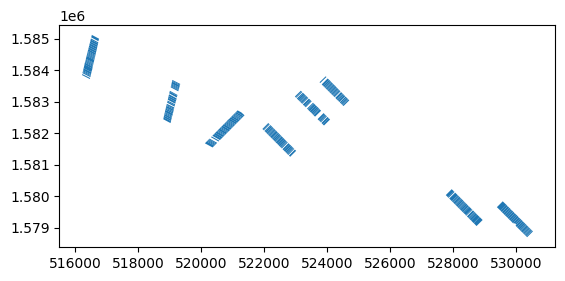

In [ ]:
# Plotting the farms with different colors for the different tertiary units
gdf.plot()

As you can see from the above plot, we have information from 8 tertiary units with several fields within each tertiary unit.

You can get the name of the fields using the following code:

In [12]:
# get the name of the fields
np.unique(gdf['layer'])

array(['BahiEddin11', 'BahiEddin21', 'BahiEddin3', 'Eltukl10',
       'FakiMusa1', 'FakiMusa6', 'FakiMusa9', 'Hegeiliga_Median'],
      dtype=object)

We want to find all the fields within one tertiary unit. We will use the following code to find all fields within the **`'FakiMusa6'`** unit as an example:



In [13]:
## Find all fields within one tertiary unit (FakiMusa6)
farms_Faki = gdf[gdf['layer']=='FakiMusa6']
farms_Faki


,id,yield,layer,path,geometry
136,2201,2.25,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"MULTIPOLYGON (((524055.126 1582470.685, 524096..."
137,2202,2.60,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"MULTIPOLYGON (((523821.720 1582321.897, 524014..."
138,2203,1.98,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"MULTIPOLYGON (((523974.387 1582548.666, 523996..."
139,2204,1.81,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"MULTIPOLYGON (((523952.826 1582571.308, 523975..."
140,2205,2.38,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"MULTIPOLYGON (((523932.536 1582591.013, 523952..."
141,2206,2.25,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"MULTIPOLYGON (((523890.261 1582634.618, 523933..."
142,2207,1.69,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"MULTIPOLYGON (((523768.945 1582749.492, 523812..."
143,2208,2.38,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"MULTIPOLYGON (((523748.227 1582774.232, 523772..."
144,2209,2.64,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"MULTIPOLYGON (((523726.667 1582797.294, 523748..."
145,2210,2.18,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"MULTIPOLYGON (((523683.551 1582838.380, 523727..."


**Excercise 1** We have information about several fields within this tertiary unit. Can you find out how many fields within this tertiary unit are listed in this DataFrame? Note down this answer, you need it in the MOOC quiz!

HINT: check out **Exercise 3** of [Notebook 01 Introduction to Pandas and Geopandas](https://github.com/wateraccounting/WaPORMOOC/blob/main/3_Python_for_WaPOR/N01_Intro_Pandas_and_Geopandas.ipynb)

In [ ]:
# Number of Polygons in FakiMusa6 field





---



<div class="alert alert-success">

## **Step 5: EXERCISE**:

>Do the zonal statistics for tertiary unit **`'FAkiMusa6`** and get the minimum, maximum and mean of the seasonal average AETI and the area of each farm.

>Note down the values (rounded to the integer values), you will need them for the MOOC quiz.


<details>
  <summary>Hints</summary>

>Select the field **`'FakiMusa6'`** from the geodataframe (at the 13th cell) and run the last three cells.

</details>
    
</div>



In [ ]:
# create a Pandas DataFrame with the seasonal AETI, area and ID of each polygon


# applying the above functions to get minimum, maximum and mean of the AETI and the area



Finally with the script below you can export the Dataframe and statistics for the tertiary unit FakiMusa6.

In [14]:
# for dataframe df
farm_name = farms_Faki.layer.iloc[0]
file_name1 = f'AETI_and_Area_per_farm_('farm_name')_tertiary_unit.csv'
df.to_csv(file_name1)

# for dataframe mm
file_name2 = f'Stat_for_('farm_name')_farms.csv'
mm.to_csv(file_name2)

#download the two csv files
files.download(file_name1)
files.download(file_name2)

SyntaxError: invalid syntax (<ipython-input-14-70a6f7f7b1c2>, line 3)



---



## **Step 6 Visualising dekadal AETI time series**
In you want to get a timeseries of dekadal AETI per farm, you can run the following three cells and using the dataframe of the tertiary unit **`'FakiMusa6'`**

### **Steps:**

1. Upload the timeseries downloaded for Notebook 02.

2. Use the same tertiary unit as above (FakiMusa6) and the dekadal AETI data
3. Iterate over the farms of the tertiary unit, clip the dataarray by each farm and compute the average AETI per farm
4. Save the result of each iteration in a dictionary (dekadal_AETI)
5. Convert the dictionary to a dataframe
6. Assign the dataarray time to index of the dataframe
7. Plot the dataframe



To start working with the Wad Helal AETI dekadal data we follow the following steps:
*  Upload .zip to your colab files
*  Unzip file
*  Get list of files


In [ ]:
#To upload file.
from google.colab import files
uploaded = files.upload()

Saving data.zip to data.zip


In [ ]:
# unzip the uploaded zipfile
!unzip '/content/data.zip' -d '/content/'

Archive:  /content/data.zip
   creating: /content/content/output/
   creating: /content/content/output/L3-AETI-D/
  inflating: /content/content/output/L3-AETI-D/Wad_Helal.GEZ_L3-AETI-D_NONE_dekad_converted_2023-03-01.tif  
  inflating: /content/content/output/L3-AETI-D/Wad_Helal.GEZ_L3-AETI-D_NONE_dekad_converted_2023-04-11.tif  
  inflating: /content/content/output/L3-AETI-D/Wad_Helal.GEZ_L3-AETI-D_NONE_dekad_converted_2023-02-21.tif  
  inflating: /content/content/output/L3-AETI-D/Wad_Helal.GEZ_L3-AETI-D_NONE_dekad_converted_2022-11-11.tif  
  inflating: /content/content/output/L3-AETI-D/Wad_Helal.GEZ_L3-AETI-D_NONE_dekad_converted_2022-11-01.tif  
  inflating: /content/content/output/L3-AETI-D/Wad_Helal.GEZ_L3-AETI-D_NONE_dekad_converted_2022-12-11.tif  
  inflating: /content/content/output/L3-AETI-D/Wad_Helal.GEZ_L3-AETI-D_NONE_dekad_converted_2022-10-11.tif  
  inflating: /content/content/output/L3-AETI-D/Wad_Helal.GEZ_L3-AETI-D_NONE_dekad_converted_2023-01-21.tif  
  inflating: /

In [ ]:
rst_fh = glob.glob('/content/content/output/data/L3-AETI-D/*.tif')
rst_fh # this holds the list of raster files found in the 'L3-AETI-D.zip' file.


[]

Calculating mean dekadal values of AETI for all farms within the Faki_Musa6 tertiary unit, and create a DataFrame.

In [ ]:
dekadal_AETI = {}

ds = ds.where(ds!=ds.attrs['_FillValue'])

for index, row in farms_Faki.iterrows():
  shdf = farms_Faki.loc[[index]]

  if(not shdf.geometry.item().is_empty):
      da = ds.rio.clip(shdf.geometry, farms_Faki.crs, all_touched=True, drop=True)
      # compute AETI of the polygon
      d2 = da.mean(dim=['latitude','longitude'], skipna = True)
      dekadal_AETI[shdf.id.values[0]] = d2.values


ValueError: 'latitude' not found in array dimensions ('band', 'y', 'x')

In [ ]:
df2 = pd.DataFrame(dekadal_AETI)
df2.index = ds.time.values
df2.round()

In [ ]:
# save the dataframe and download to local folder
file_name = f'dekadal_AETI_timeseries_for_{farm_name}_field.csv'
df2.to_csv(file_name3)

#download the two csv files
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##**Plotting with Pandas**

There are multiple ways of many plots - one is to use the inbuilt function from pandas (which uses matplotlib in the backend by default), and another is to use matplotlib directly. We will briefly look into both of these.
To start, let us use the .plot() function you have seen in the previous notebook. We can plot all of the series at once:


In [ ]:
# Plot the dataframe
df2.plot(figsize = (12,6))

or or select one column to plot:

In [ ]:
df2['2202'].plot()


Here we can see the default plot for this type of data.
A number of elements are missing, for example a title, axis labels and units... These elements can be added/changed by adding arguments to the .plot() call.

* The axis labels `ylabel`
* The plot title with `title`
* The line `style`
* The figure size with `figsize`

You can find a reference for the different options [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)

In [ ]:
df2['2202'].plot(ylabel='mm/dekad', title='Mean Dekadal AETI for Plot Number 2202', figsize=(10,3), style='--');


You may also want to produce scatter plots, or xy plots to compare how the ET of two plots compares. You can do this by changing the style of your plot and defining the x and y variables as shown below.


In [ ]:
df2.plot(x='2202', y='2203', style='.')

##**Plotting with MatPlotLib**

This .plot() call will only work on a dataframe, so if you have data in arrays or lists or if you want to make certain kinds of plots and have better control over your figure you may need to use matplotlib instead.
To make a similar plot to that of the scatter above, we can use the scatter function from matplotlib.pyplot (imported as plt in cell 1):

In [ ]:

plt.figure(figsize=[5, 5])
plt.scatter(df2['2202'],df2['2203']);

For such a plot it makes sense for the x and y limits to be harmonizes, to add a grid and to add the 1:1 line, as well as our standards, the labels and a title. To do these things, it can be helpful to have a direct way to interact with the axes, for this we will start with defining a figure and axes




In [ ]:
fig, ax = plt.subplots(figsize=[5, 5])

ax.set_ylim([0,80]);
ax.set_xlim([0,80]);
ax.grid(True)

ax.plot([0,80],[0,80],color='grey', linestyle='--')
ax.scatter(df2['2202'],df['2203']);

ax.set_ylabel('Plot #2203')
ax.set_xlabel('Plot #2202')

plt.title('AETI comparison between Plots #2203 and 2202');

In [ ]:
# # if you want to delete a folder use the code below.
# !rm -rf /content/L3-AETI-D
# !rm -rf /content/tifs
# !rm -rf /content/L3-AETI-D.zip